In [5]:
import os, glob
import sys
from sys import stderr
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import datetime
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.enable_eager_execution()
from tensorflow.keras import backend as K, preprocessing, \
                             models, layers, optimizers, \
                             utils, callbacks, initializers, \
                             activations, regularizers, applications, \
                             constraints, Model
import numpy as np
import numpy.random as rand
import six
import cv2 as cv
import pandas as pd
import skimage.measure as meas
from numpy import linalg as la, random as rand
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import model_selection
from sklearn import preprocessing as spre
from tqdm import tqdm, tnrange, tqdm_notebook
from jupyterthemes import jtplot

In [6]:
jtplot.reset()
plt.style.use("bmh")
plt.rcParams["axes.axisbelow"] = True
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["figure.figsize"] = (5, 5)
plt.rcParams["figure.dpi"] = 100
plt.rcParams["text.latex.preamble"] = [r"\usepackage{physics}"]

In [7]:
class StopOnValue(callbacks.Callback):
    def __init__(self, 
                 monitor='val_loss', 
                 value=0.00001, 
                 mode='min',
                 verbose=0):
        super(callbacks.Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose
        self.mode = mode
        if self.mode == 'min':
            self.compare_op = np.less
        elif self.mode == 'max':
            self.compare_op = np.greater
    
    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn('Early stopping requires %s available!' % self.monitor, RuntimeWarning)
            
        if self.compare_op(current, self.value):
            if self.verbose > 0:
                print('Epoch %05d: early stopping THR' % epoch)
            self.model.stop_training = True
            
            
class AdaBound(optimizers.Optimizer):
    def __init__(self,
                 lr=0.001,
                 final_lr=0.1,
                 beta_1=0.9,
                 beta_2=0.999,
                 gamma=1e-3,
                 epsilon=None,
                 decay=0.,
                 amsbound=False,
                 weight_decay=0.,
                 **kwargs):
        """
        Keras port [1] of AdaBound Optimizer for PyTorch [2], from the paper 
        Adaptive Gradient Methods with Dynamic Bound of Learning Rate [3].
        
        AdaBound optimizer.
        
        Default parameters follow those provided in the original paper.
        # Arguments
            lr: float >= 0. Learning rate.
            final_lr: float >= 0. Final learning rate.
            beta_1: float, 0 < beta < 1. Generally close to 1.
            beta_2: float, 0 < beta < 1. Generally close to 1.
            gamma: float >= 0. Convergence speed of the bound function.
            epsilon: float >= 0. Fuzz factor. If `None`, defaults to `K.epsilon()`.
            decay: float >= 0. Learning rate decay over each update.
            weight_decay: Weight decay weight.
            amsbound: boolean. Whether to apply the AMSBound variant of this
                algorithm.
        
        [1] Majumdar, S. keras-adabound, 2019. https://github.com/titu1994/keras-adabound.
        [2] Luo, L. AdaBound, 2019. https://github.com/Luolc/AdaBound.
        [3] Luo, L., Yuanhao, X., Yan, L., and Xu, S. Adaptive gradient methods with dynamic
            bound of learning rate. International Conference on LEarning Representations, 2019.
            https://openreview.net/forum?id=Bkg3g2R9FX.
        """
        super(AdaBound, self).__init__(**kwargs)
        
        if not 0. < gamma <= 1.:
            raise ValueError('Invalid `gamma` parameter. Must lie in [0, 1] range.')
            
        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.lr = K.variable(lr, name='lr')
            self.beta_1 = K.variable(beta_1, name='beta_1')
            self.beta_2 = K.variable(beta_2, name='beta_2')
            self.decay = K.variable(decay, name='decay')
            
        self.final_lr = final_lr
        self.gamma = gamma
        
        if epsilon is None:
            epsilon = K.epsilon()
        self.epsilon = epsilon
        self.initial_decay = decay
        self.amsbound = amsbound

        self.weight_decay = float(weight_decay)
        self.base_lr = float(lr)
        
        
    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]

        lr = self.lr
        if self.initial_decay > 0:
            lr = lr * (1. / (1. + self.decay * K.cast(self.iterations,
                                                      K.dtype(self.decay))))

        t = K.cast(self.iterations, K.floatx()) + 1

        # Applies bounds on actual learning rate
        step_size = lr * (K.sqrt(1. - K.pow(self.beta_2, t)) /
                          (1. - K.pow(self.beta_1, t)))

        final_lr = self.final_lr * lr / self.base_lr
        lower_bound = final_lr * (1. - 1. / (self.gamma * t + 1.))
        upper_bound = final_lr * (1. + 1. / (self.gamma * t))

        ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        if self.amsbound:
            vhats = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        else:
            vhats = [K.zeros(1) for _ in params]
        self.weights = [self.iterations] + ms + vs + vhats

        for p, g, m, v, vhat in zip(params, grads, ms, vs, vhats):
            # apply weight decay
            if self.weight_decay != 0.:
                g += self.weight_decay * K.stop_gradient(p)

            m_t = (self.beta_1 * m) + (1. - self.beta_1) * g
            v_t = (self.beta_2 * v) + (1. - self.beta_2) * K.square(g)

            if self.amsbound:
                vhat_t = K.maximum(vhat, v_t)
                denom = (K.sqrt(vhat_t) + self.epsilon)
                self.updates.append(K.update(vhat, vhat_t))
            else:
                denom = (K.sqrt(v_t) + self.epsilon)

            # Compute the bounds
            step_size_p = step_size * K.ones_like(denom)
            step_size_p_bound = step_size_p / denom
            bounded_lr_t = m_t * K.minimum(K.maximum(step_size_p_bound,
                                                     lower_bound), upper_bound)

            p_t = p - bounded_lr_t

            self.updates.append(K.update(m, m_t))
            self.updates.append(K.update(v, v_t))
            new_p = p_t

            # Apply constraints.
            if getattr(p, 'constraint', None) is not None:
                new_p = p.constraint(new_p)

            self.updates.append(K.update(p, new_p))
        return self.updates
    
    
    def get_config(self):
        config = {'lr': float(K.get_value(self.lr)),
                  'final_lr': float(self.final_lr),
                  'beta_1': float(K.get_value(self.beta_1)),
                  'beta_2': float(K.get_value(self.beta_2)),
                  'gamma': float(self.gamma),
                  'decay': float(K.get_value(self.decay)),
                  'epsilon': self.epsilon,
                  'weight_decay': self.weight_decay,
                  'amsbound': self.amsbound}
        base_config = super(AdaBound, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


class TQDMCallback(callbacks.Callback):
    def __init__(self, outer_description="Training",
                 inner_description_initial="Epoch: {epoch}",
                 inner_description_update="Epoch: {epoch} - {metrics}",
                 metric_format="{name}: {value:0.3f}",
                 separator=", ",
                 leave_inner=True,
                 leave_outer=True,
                 show_inner=True,
                 show_outer=True,
                 output_file=stderr,
                 initial=0):
        """
        Construct a callback that will create and update progress bars.

        :param outer_description: string for outer progress bar
        :param inner_description_initial: initial format for epoch ("Epoch: {epoch}")
        :param inner_description_update: format after metrics collected ("Epoch: {epoch} - {metrics}")
        :param metric_format: format for each metric name/value pair ("{name}: {value:0.3f}")
        :param separator: separator between metrics (", ")
        :param leave_inner: True to leave inner bars
        :param leave_outer: True to leave outer bars
        :param show_inner: False to hide inner bars
        :param show_outer: False to hide outer bar
        :param output_file: output file (default sys.stderr)
        :param initial: Initial counter state
        """
        self.outer_description = outer_description
        self.inner_description_initial = inner_description_initial
        self.inner_description_update = inner_description_update
        self.metric_format = metric_format
        self.separator = separator
        self.leave_inner = leave_inner
        self.leave_outer = leave_outer
        self.show_inner = show_inner
        self.show_outer = show_outer
        self.output_file = output_file
        self.tqdm_outer = None
        self.tqdm_inner = None
        self.epoch = None
        self.running_logs = None
        self.inner_count = None
        self.initial = initial

    def tqdm(self, desc, total, leave, initial=0):
        """
        Extension point. Override to provide custom options to tqdm initializer.
        :param desc: Description string
        :param total: Total number of updates
        :param leave: Leave progress bar when done
        :param initial: Initial counter state
        :return: new progress bar
        """
        return tqdm(desc=desc, total=total, leave=leave, file=self.output_file, initial=initial)

    def build_tqdm_outer(self, desc, total):
        """
        Extension point. Override to provide custom options to outer progress bars (Epoch loop)
        :param desc: Description
        :param total: Number of epochs
        :return: new progress bar
        """
        return self.tqdm(desc=desc, total=total, leave=self.leave_outer, initial=self.initial)

    def build_tqdm_inner(self, desc, total):
        """
        Extension point. Override to provide custom options to inner progress bars (Batch loop)
        :param desc: Description
        :param total: Number of batches
        :return: new progress bar
        """
        return self.tqdm(desc=desc, total=total, leave=self.leave_inner)

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch = epoch
        desc = self.inner_description_initial.format(epoch=self.epoch)
        self.mode = 0  # samples
        if 'samples' in self.params:
            self.inner_total = self.params['samples']
        elif 'nb_sample' in self.params:
            self.inner_total = self.params['nb_sample']
        else:
            self.mode = 1  # steps
            self.inner_total = self.params['steps']
        if self.show_inner:
            self.tqdm_inner = self.build_tqdm_inner(desc=desc, total=self.inner_total)
        self.inner_count = 0
        self.running_logs = {}

    def on_epoch_end(self, epoch, logs={}):
        metrics = self.format_metrics(logs)
        desc = self.inner_description_update.format(epoch=epoch, metrics=metrics)
        if self.show_inner:
            self.tqdm_inner.desc = desc
            # set miniters and mininterval to 0 so last update displays
            self.tqdm_inner.miniters = 0
            self.tqdm_inner.mininterval = 0
            self.tqdm_inner.update(self.inner_total - self.tqdm_inner.n)
            self.tqdm_inner.close()
        if self.show_outer:
            self.tqdm_outer.update(1)

    def on_train_batch_begin(self, batch, logs={}):
        pass

    def on_train_batch_end(self, batch, logs={}):
        if self.mode == 0:
            update = logs['size']
        else:
            update = 1
        self.inner_count += update
        if self.inner_count < self.inner_total:
            self.append_logs(logs)
            metrics = self.format_metrics(self.running_logs)
            desc = self.inner_description_update.format(epoch=self.epoch, metrics=metrics)
            if self.show_inner:
                self.tqdm_inner.desc = desc
                self.tqdm_inner.update(update)

    def on_train_begin(self, logs={}):
        if self.show_outer:
            epochs = (self.params['epochs'] if 'epochs' in self.params
                      else self.params['nb_epoch'])
            self.tqdm_outer = self.build_tqdm_outer(desc=self.outer_description,
                                                    total=epochs)

    def on_train_end(self, logs={}):
        if self.show_outer:
            self.tqdm_outer.close()

    def append_logs(self, logs):
        metrics = self.params['metrics']
        for metric, value in six.iteritems(logs):
            if metric in metrics:
                if metric in self.running_logs:
                    self.running_logs[metric].append(value[()])
                else:
                    self.running_logs[metric] = [value[()]]

    def format_metrics(self, logs):
        metrics = self.params['metrics']
        strings = [self.metric_format.format(name=metric, value=np.mean(logs[metric], axis=None)) for metric in metrics
                   if
                   metric in logs]
        return self.separator.join(strings)


class TQDMNotebookCallback(TQDMCallback):
    def __init__(self,
                 outer_description="Training",
                 inner_description_initial="Epoch {epoch}",
                 inner_description_update="[{metrics}] ",
                 metric_format="{name}: {value:0.3f}",
                 separator=", ",
                 leave_inner=False,
                 leave_outer=True,
                 output_file=sys.stderr,
                 initial=0, **kwargs):
        super(TQDMNotebookCallback, self).__init__(outer_description=outer_description,
                                                   inner_description_initial=inner_description_initial,
                                                   inner_description_update=inner_description_update,
                                                   metric_format=metric_format,
                                                   separator=separator,
                                                   leave_inner=leave_inner,
                                                   leave_outer=leave_outer,
                                                   output_file=output_file,
                                                   initial=initial, **kwargs)

    def tqdm(self, desc, total, leave, initial=0):
        """
        Extension point. Override to provide custom options to tqdm_notebook initializer.
        :param desc: Description string
        :param total: Total number of updates
        :param leave: Leave progress bar when done
        :return: new progress bar
        :param initial: Initial counter state
        """
        return tqdm_notebook(desc=desc, total=total, leave=leave, initial=initial)
    
    
def l2loss(y_true, y_pred):
    if y_true.shape != y_pred.shape:
        y_true = tf.image.resize(y_true, tf.shape(y_pred)[1:3])
    return tf.nn.l2_loss(y_pred - y_true)

def shannonEntropy2D(img, base=2):       
    img_grad = np.asarray(np.gradient(img)).T
    img_grad /= img_grad.max()
    img_grad = np.uint8(img_grad * 255)
    hist = np.squeeze(cv.calcHist([img_grad], [0, 1], None, [256, 256], [0, 256, 0, 256]))
    hist /= img_grad.size
    with warn.catch_warnings():
        warn.simplefilter('ignore')
        if base == 2:
            log = np.log2
        elif base == 10:
            log = np.log10
        elif base == 'e':
            log = np.log
        H = -1/2 * np.nansum(hist*log(hist))
    return H

In [8]:
# traindir = 'D:/Kenneth/Documents/VIP/Datasets/cat-and-dog/TRAIN/'
testdir = 'D:/Kenneth/Documents/VIP/Datasets/cat-and-dog/TEST/'
traindir = 'D:/Kenneth/Documents/VIP/Datasets/dogs-vs-cats/TRAIN/'
# testdir = 'D:/Kenneth/Documents/VIP/Datasets/dogs-vs-cats/TEST/'
img_w, img_h, img_ch = 224, 224, 3

In [9]:
filenames = os.listdir(traindir)
categories = []
for f in filenames:
    category = f.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)
        
df = pd.DataFrame({'filename': filenames,
                   'category': categories})
df['category'] = df['category'].replace({0: 'cat', 
                                         1: 'dog'})

In [10]:
train_df, val_df = model_selection.train_test_split(df, test_size=0.2, random_state=401)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

total_train = train_df.shape[0]
total_val = val_df.shape[0]
batch_size = 128
epochs = int(1e6)

In [11]:
train_datagen = preprocessing.image.ImageDataGenerator(rescale=1/255,
#                                                        rotation_range=15,
#                                                        shear_range=0.1,
#                                                        zoom_range=0.2,
#                                                        horizontal_flip=True,
#                                                        width_shift_range=0.1,
#                                                        height_shift_range=0.1
                                                      )
train_gen = train_datagen.flow_from_dataframe(train_df,
                                              traindir,
                                              x_col='filename',
                                              y_col='category',
                                              target_size=(img_w, img_h),
                                              batch_size=batch_size,
                                              class_mode='binary')

Found 20000 validated image filenames belonging to 2 classes.


In [12]:
val_datagen = preprocessing.image.ImageDataGenerator(rescale=1/255)
val_gen = val_datagen.flow_from_dataframe(val_df,
                                          traindir,
                                          x_col='filename',
                                          y_col='category',
                                          target_size=(img_w, img_h),
                                          batch_size=batch_size,
                                          class_mode='binary')

Found 5000 validated image filenames belonging to 2 classes.


In [13]:
def tfdata_generator(datagen):
    dataset = tf.data.Dataset.from_generator(lambda: datagen,
                                             output_types=(tf.float32, tf.float32))
    dataset = dataset.prefetch(tf.contrib.data.AUTOTUNE)
    return dataset

In [14]:
train_ds = tfdata_generator(train_gen)
val_ds = tfdata_generator(val_gen)

In [17]:
conv_layers = []
for i, f in enumerate([32, 64, 128, 128]):
    conv = layers.Conv2D(filters=f,
                         kernel_size=3,
                         activation='relu',
                         name='conv%s' % str(i+1))
    pool = layers.MaxPooling2D(pool_size=3,
                               strides=2,
                               name='pool%s' % str(i+1))
    conv_layers.append(conv)
    conv_layers.append(pool)
model = models.Sequential([layers.Input(shape=(img_w, img_h, img_ch)),
                           *conv_layers,
                           layers.Flatten(name='flatten'),
                           layers.Dense(units=512,
                                        activation='relu',
                                        name='fc1'),
                           layers.Dense(units=1,
                                        activation='sigmoid',
                                        name='output')
                         ])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 222, 222, 32)      896       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 110, 110, 32)      0         
_________________________________________________________________
conv2 (Conv2D)               (None, 108, 108, 64)      18496     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 53, 53, 64)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 51, 51, 128)       73856     
_________________________________________________________________
pool3 (MaxPooling2D)         (None, 25, 25, 128)       0         
_________________________________________________________________
conv4 (Conv2D)               (None, 23, 23, 128)       1

In [18]:
stopval = StopOnValue(monitor='val_loss',
                      value=0.1,
                      mode='min',
                      verbose=1)
lrred = callbacks.ReduceLROnPlateau(monitor='val_loss',
                                    factor=1/10,
                                    mode='min',
                                    min_lr=1e-4,
                                    verbose=1)
checkpoint = callbacks.ModelCheckpoint('catdog.model',
                                       monitor='val_loss',
                                       verbose=1,
                                       save_best_only=True,
                                       mode='min')
# tblogdir = log_dir='./.tb_logs/%s/' \
#            %(datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
# os.makedirs(tblogdir)
# tblog = callbacks.TensorBoard(tblogdir,
#                               histogram_freq=5,
#                               batch_size=batch_size,
#                               write_images=True,
#                               embeddings_freq=0,
#                               update_freq='epoch')
csv = callbacks.CSVLogger('catdog.log', 
                          separator=',')
sgd = optimizers.SGD(lr=0.01,
                     momentum=0.9,
                     decay=5e-4)

In [19]:
model.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['acc'])

In [62]:
history = model.fit(train_ds,
                    epochs=epochs,
                    validation_data=val_ds,
                    validation_steps=total_val//batch_size,
                    steps_per_epoch=total_train//batch_size,
                    callbacks=[stopval, lrred, checkpoint, csv],
                    verbose=1)

Epoch 1/1000000
155/156 [============================>.] - ETA: 0s - loss: 0.5835 - acc: 0.6893
Epoch 00001: val_loss improved from inf to 0.51760, saving model to catdog.model
156/156 [==============================] - 136s 871ms/step - loss: 0.5827 - acc: 0.6901 - val_loss: 0.5176 - val_acc: 0.7494
Epoch 2/1000000
155/156 [============================>.] - ETA: 0s - loss: 0.5123 - acc: 0.7420
Epoch 00002: val_loss improved from 0.51760 to 0.48354, saving model to catdog.model
156/156 [==============================] - 136s 873ms/step - loss: 0.5120 - acc: 0.7423 - val_loss: 0.4835 - val_acc: 0.7684
Epoch 3/1000000
155/156 [============================>.] - ETA: 0s - loss: 0.4522 - acc: 0.7884
Epoch 00003: val_loss improved from 0.48354 to 0.42749, saving model to catdog.model
156/156 [==============================] - 138s 883ms/step - loss: 0.4516 - acc: 0.7886 - val_loss: 0.4275 - val_acc: 0.8035
Epoch 4/1000000
155/156 [============================>.] - ETA: 0s - loss: 0.4091 - ac

Epoch 30/1000000
118/156 [=====================>........] - ETA: 32s - loss: 0.0021 - acc: 1.0000

KeyboardInterrupt: 

In [20]:
model.load_weights('catdog.model')

In [64]:
history = np.genfromtxt('catdog.log', delimiter=',', skip_header=1, unpack=True)
keys = ['epoch', 'acc', 'loss', 'lr', 'val_acc', 'val_loss']
history = dict(zip(keys, history))
epochs = len(history['epoch'])

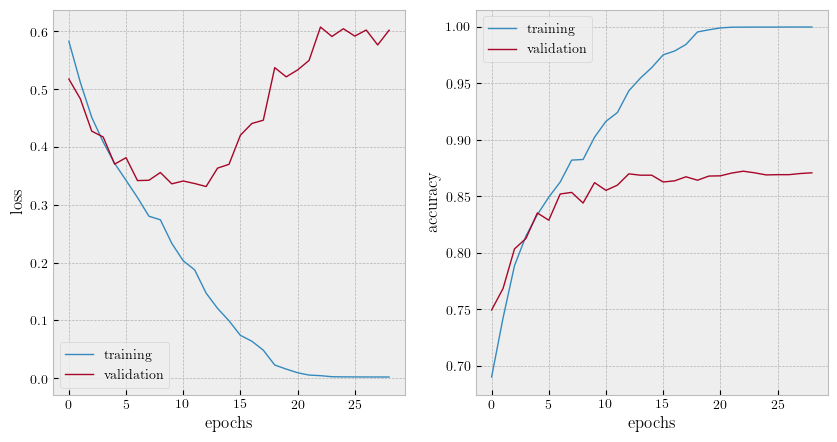

In [179]:
fig = plt.figure(figsize=(5*2, 5))

ax = fig.add_subplot(121)
ax.plot(range(epochs), history['loss'], lw=1, label='training')
ax.plot(range(epochs), history['val_loss'], lw=1, label='validation')
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
ax.legend()

ax = fig.add_subplot(122)
ax.plot(range(epochs), history['acc'], lw=1, label='training')
ax.plot(range(epochs), history['val_acc'], lw=1, label='validation')
ax.set_xlabel('epochs')
ax.set_ylabel('accuracy')
ax.legend()

# plt.savefig('loss-acc.png', dpi=300, bbox_inches='tight')
plt.show()

In [21]:
test_filenames = os.listdir(testdir)
categories = []
for f in test_filenames:
    fn = f.split('.')[0]
    categories.append(0 if fn == 'cat' else 1)

test_df = pd.DataFrame({'filename': test_filenames,
                        'category': categories})
test_df['category'] = test_df['category'].replace({0: 'cat',
                                                   1: 'dog'})
# test_df = test_df.sample(n=500, replace=False, random_state=42)
# test_df = test_df.reset_index(drop=True)
total_test = test_df.shape[0]

In [22]:
test_gen = preprocessing.image.ImageDataGenerator(rescale=1/255)
test_datagen = test_gen.flow_from_dataframe(test_df,
                                            testdir,
                                            x_col='filename',
                                            y_col='category',
                                            class_mode='binary',
                                            target_size=(img_w, img_h),
                                            batch_size=batch_size,
                                            shuffle=False)
test_ds = tfdata_generator(test_datagen)

Found 2023 validated image filenames belonging to 2 classes.


In [23]:
evals = model.evaluate(test_ds, verbose=1, steps=np.ceil(total_test//batch_size))

15/15 [==============================] - 9s 622ms/step - loss: 0.1541 - acc: 0.9495


In [37]:
sample_test = test_df.sample(18, replace=False, random_state=42)
sample_test = sample_test.reset_index(drop=True)
sample_datagen = test_gen.flow_from_dataframe(sample_test,
                                              testdir,
                                              x_col='filename',
                                              y_col=None,
                                              class_mode=None,
                                              target_size=(img_w, img_h),
                                              batch_size=batch_size,
                                              shuffle=False)
total_sample = sample_test.shape[0]

Found 18 validated image filenames.


In [54]:
preds = model.predict_generator(sample_datagen,
                                verbose=1)
y_test = preds.round().astype('uint8').squeeze()

1/1 [==============================] - 0s 76ms/step


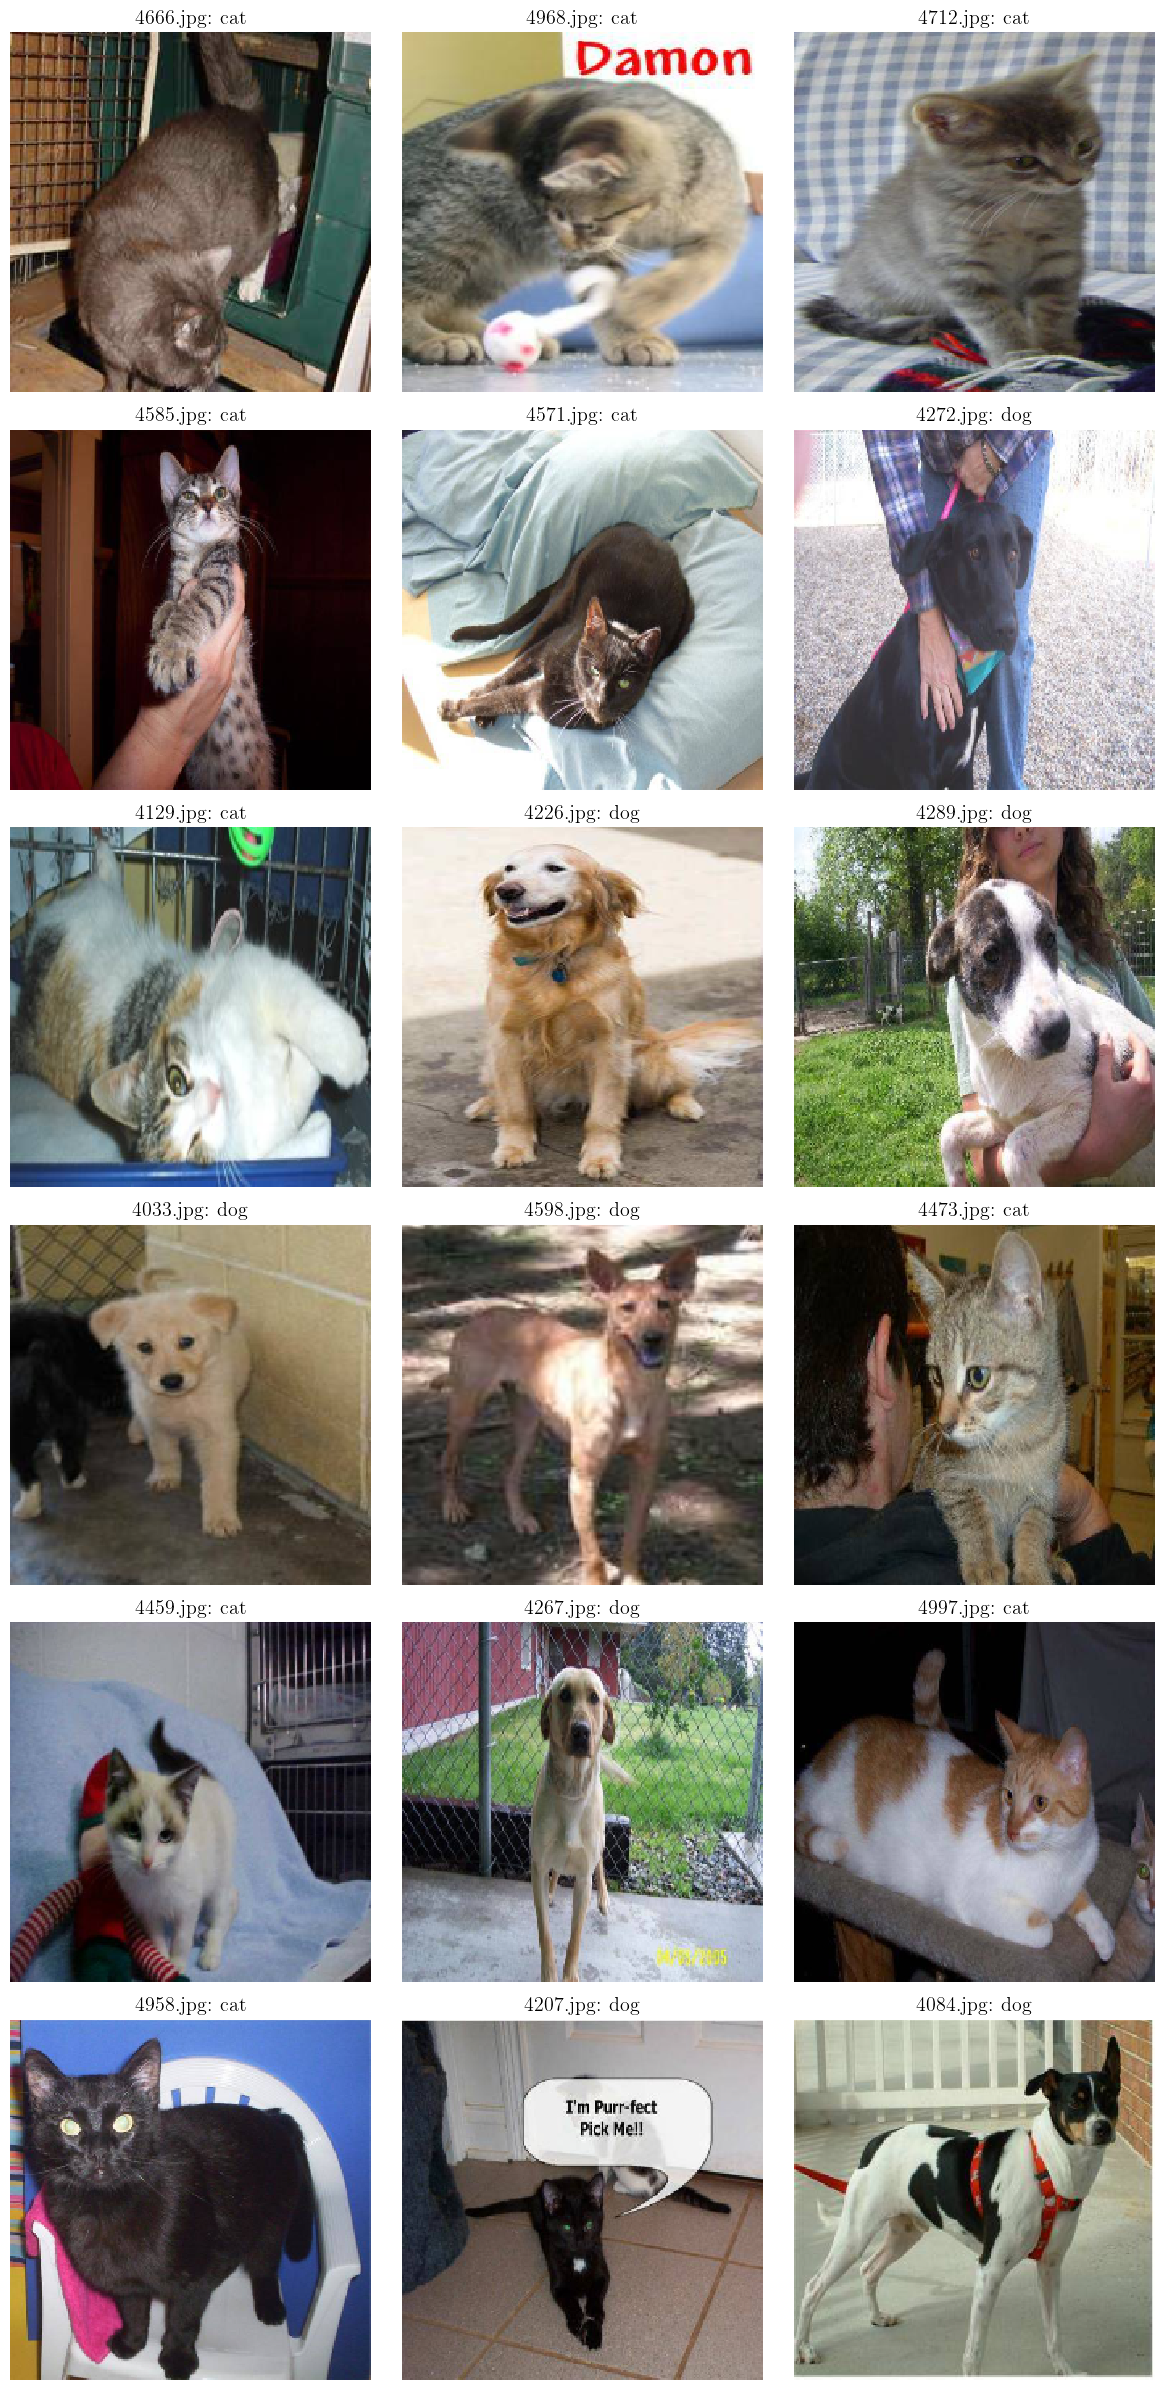

In [65]:
plt.figure(figsize=(12, 24))
for i, row in sample_test.iterrows():
    filename = row['filename']
    category = 'dog' if y_test[i] == 1 else 'cat'
    img = cv.imread(testdir + filename)
    img = cv.resize(img, (img_w, img_h))
    plt.subplot(6, 3, i+1)
    plt.imshow(img[:,:,::-1])
    plt.grid(0)
    plt.axis('off')
    plt.title('.'.join(filename.split('.')[1:]) + ': ' + str(category))
plt.tight_layout()
# plt.savefig('outputs.png', dpi=300, bbox_inches='tight')
plt.show()